<a href="https://colab.research.google.com/github/tammy-uncc/ITCS6162KDDGroup4/blob/main/KDD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITCS 6162 KDD Group 4 Final Project


## Team Members
Julie Berryhill<br>
Gabriel Van Dreel<br>
Dasha Rizvanova<br>
Manoj Aitha<br>
Tammy Ziegler<br>


## Introduction

Group 4 decided that they would like to research the possibility of whether an individual could change their lifestyle factors in time to reduce or eliminate the onset of Alzheimer's. For example, if an individual knew that a healthier diet could reduce their chance of a positive diagnosis, then they may put eating healthier as an earlier priority in their lives. This dataset includes many lifestyle factors (BMI, smoking status, alcohol consumption, physical activity, diet quality, and sleep quality) that will help in building predictive and prescriptive objectives.
We will be using supervised learning methods as the diagnosis of Alzheimer's is a known outcome in this dataset.

We will be looking into classification, clustering, and feature selection to identify and select the most relevant features to improve the predictive models. By using these approaches, group 4 hopes that this research will uncover any insights of lifestyle risk factors for developing Alzheimer’s and which lifestyle factor modifications could mitigate those risks.



## Research Question
Are there any lifestyle factors that could be changed to reduce or eliminate the onset of Alzheimers?

## Data Source
https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset?select=alzheimers_disease_data.csv

The dataset consists of 2150 entries detailing various physiological characteristics of patients who were considered for an Alzheimer’s disease diagnosis and whether they were formally diagnosed with the illness. Some of the data such as the gender and ethnicity columns is categorical while other data is numeric and represents either an index for a rating of some condition such as sleep quality or a direct measurement of some physical characteristic such as cholesterol. All of the numeric data points could be considered time series data with respect to age. Some columns in the dataset such as the name of the doctor in charge of a given patient, however, have been sanitized and provide no meaningful information.

## Data Analysis

Through our analysis we discovered some features that can be dropped sicne they provide no value to our research.  We also discovered that there are only a few features that have some semblance of correlation with the diagnosis.  The diagnosis itself is a bit weigted as only a third of the observations are a positive diagnosis. Hence we need to take that into account when reviewing the relationships with the other features of the data set.

In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

#install pandas-profiling into the environment
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Preparing metadata (setup.py) ... done


In [ ]:
# Restart kernel
import os
os._exit(00)


## Import the required modules

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport


<ipython-input-2-27d6250e83ac>:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## Load the data and drop known unnecessary features
Patient ID is a numeric identifier and has no value to the dataset other then to represent a unique individual.  DoctorInCharge is also unnecessary as it provide no value to the data.

In [3]:
# Load the data

df = pd.read_csv('/content/drive/MyDrive/ITCS 6162/alzheimers_disease_data.csv')

df = df.drop(['DoctorInCharge','PatientID'], axis=1)
df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


## Analize the data.
In the following sections we will perform various operations on the data to visualize from multiple perspectives.


### Profile the data
To start we will use Pandas Profiler to get an initial profile of the data. This will produce a report and save it as an html file.



In [ ]:
profile = ProfileReport(df, title="Alzheimer's Data Profile Report")
profile.to_file("/content/drive/MyDrive/ITCS 6162/creditcard_report.html")
profile.to_notebook_iframe()

### Perform a correlation of all features
This map is annotated in order to see the values.


In [ ]:


corr = df.corr()
plt.figure(figsize=(30,30))
plt.title('All')
sns.heatmap(corr,annot=True)



### Perform density analysis on numeric columns

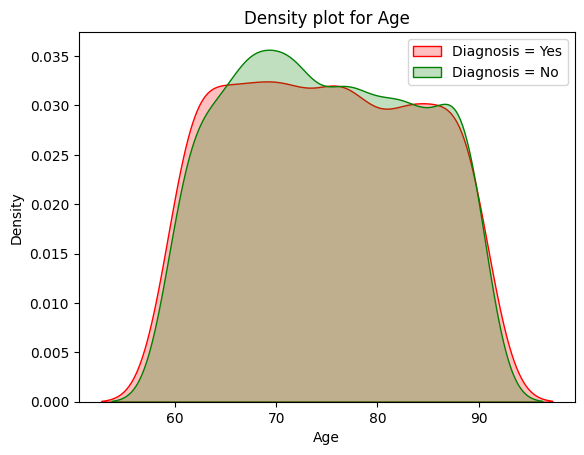

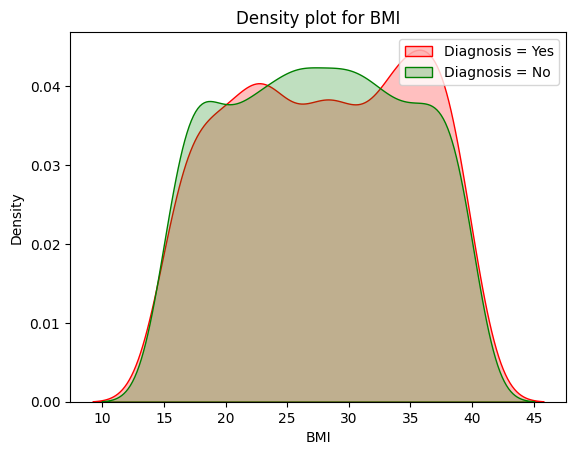

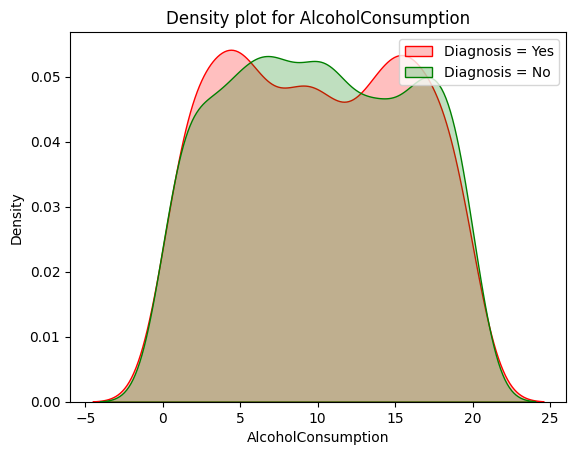

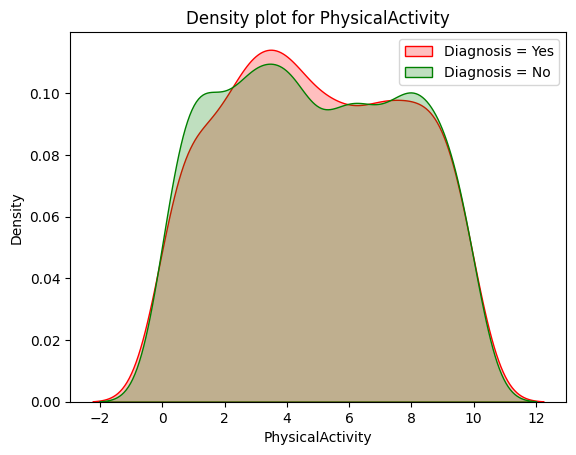

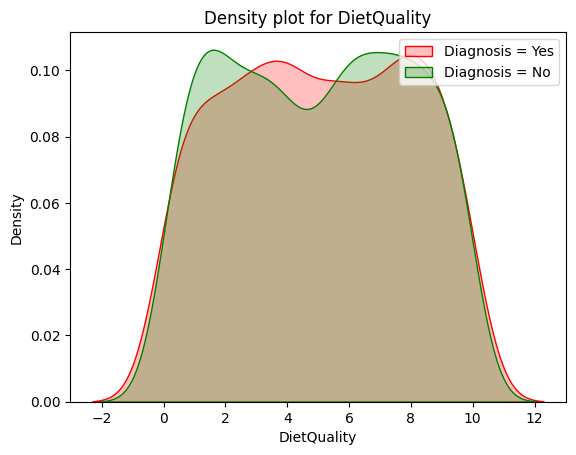

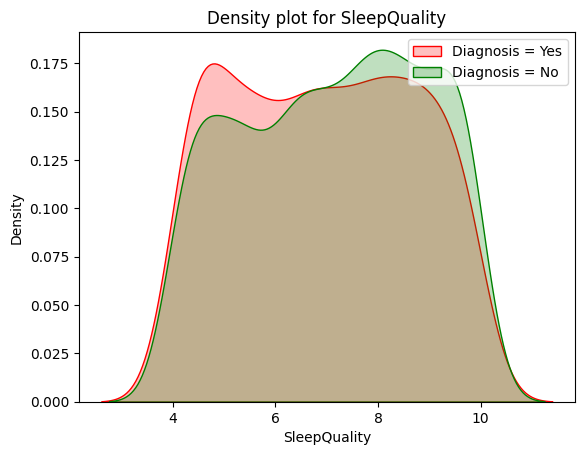

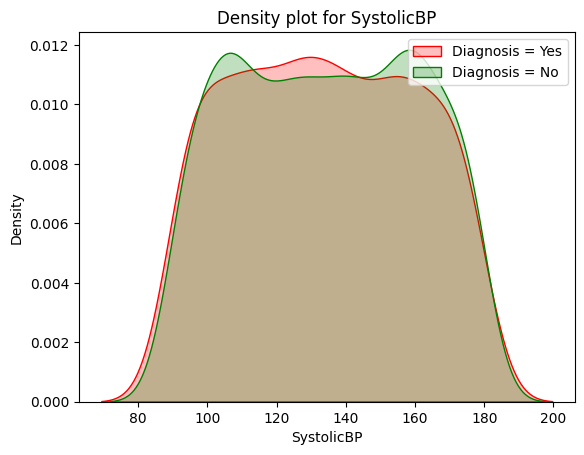

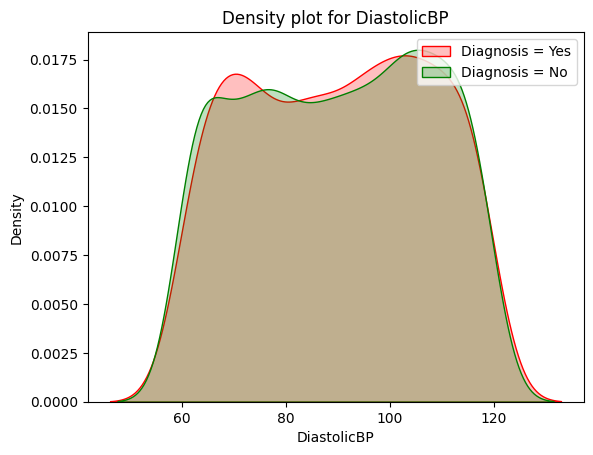

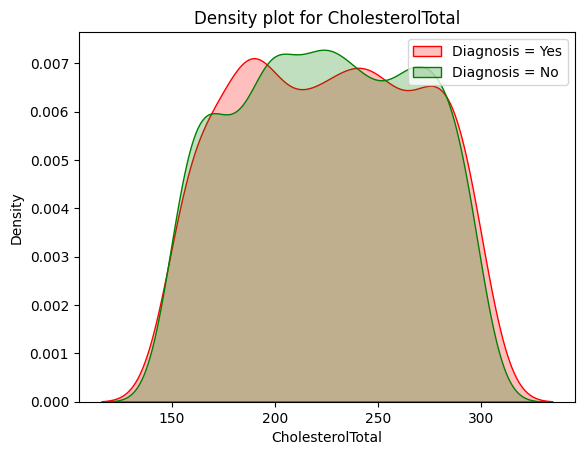

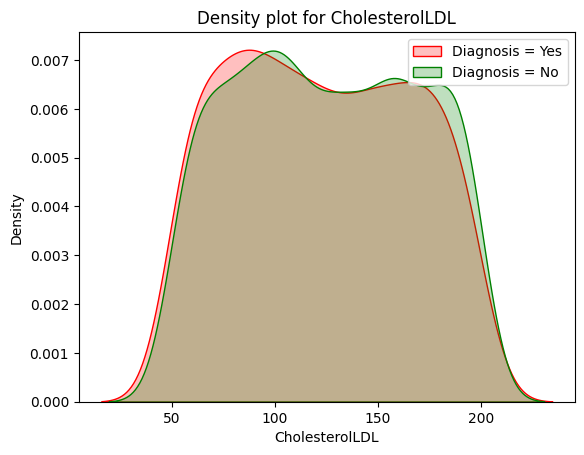

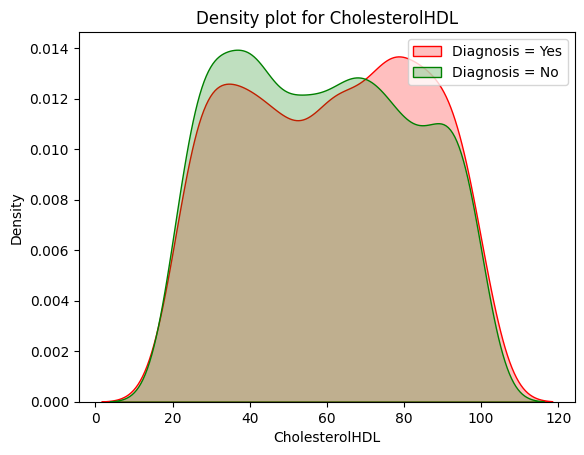

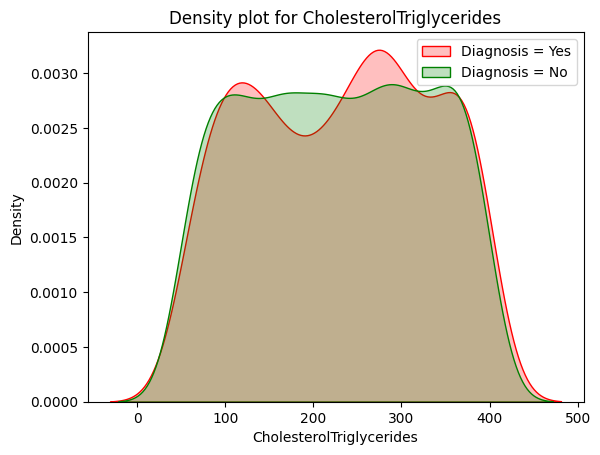

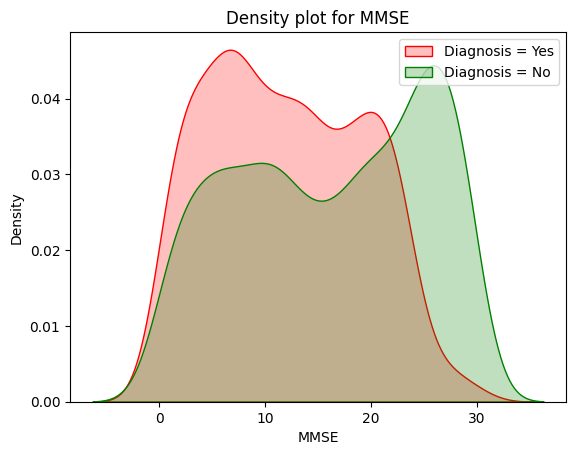

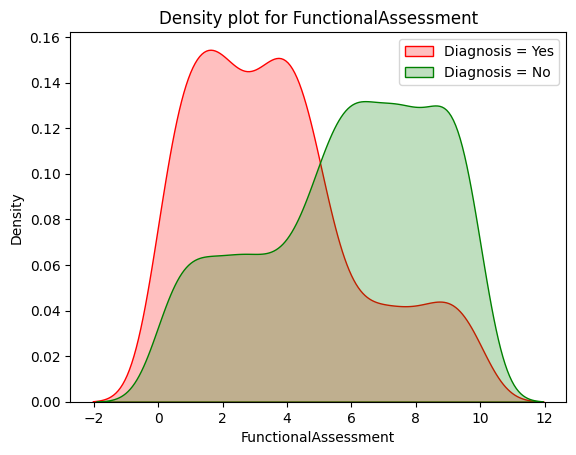

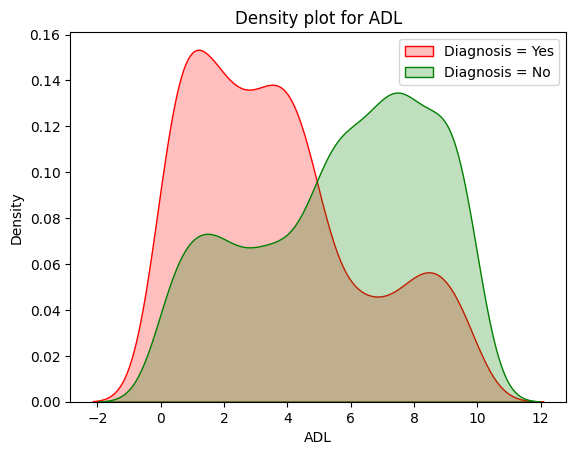

In [12]:

groups = {'category': ['Ethnicity', 'Gender', 'EducationLevel',
               'Smoking','FamilyHistoryAlzheimers',
               'CardiovascularDisease', 'Diabetes','Depression', 'HeadInjury',
               'Hypertension','MemoryComplaints','BehavioralProblems',
               'Confusion','Disorientation',
               'PersonalityChanges','DifficultyCompletingTasks',
               'Forgetfulness','Diagnosis'],
          'numeric': ['Age', 'BMI','AlcoholConsumption','PhysicalActivity',
               'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP',
               'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides','MMSE',
               'FunctionalAssessment',
               'ADL']
}

for col in groups['numeric']:
  plt.figure(col)
  sns.kdeplot(df[df['Diagnosis']==1][col], color='red',fill=True)
  sns.kdeplot(df[df['Diagnosis']==0][col], color='green',fill=True)
  plt.title(f'Density plot for {col}')
  plt.legend(['Diagnosis = Yes', 'Diagnosis = No'])
  plt.show




### Perform a distribution visualization analysis on the categorical data

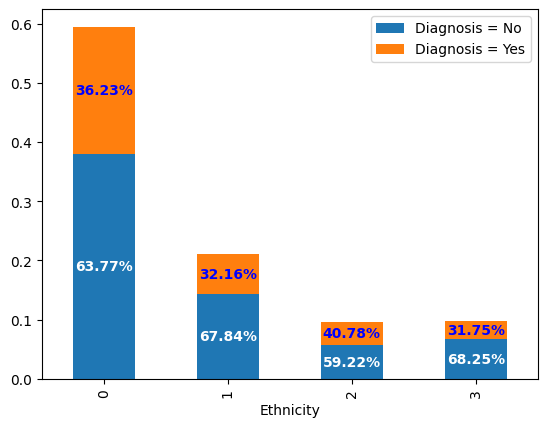

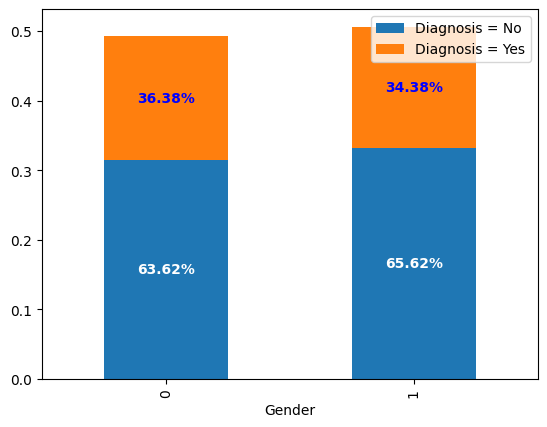

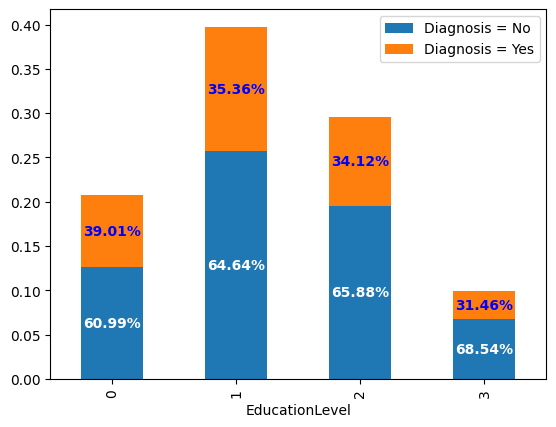

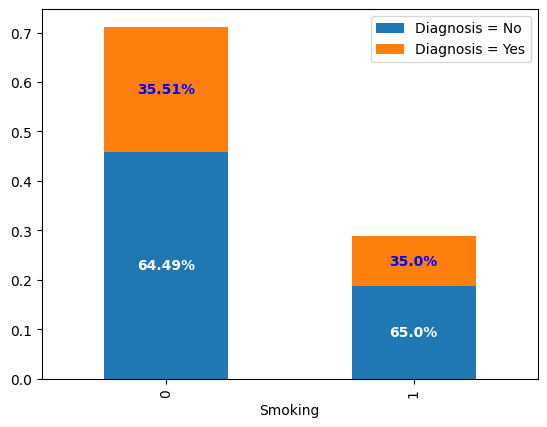

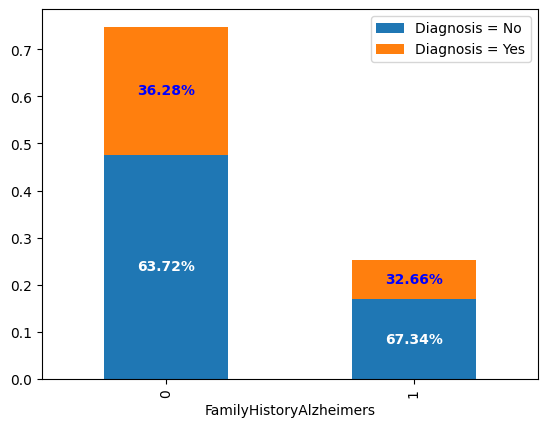

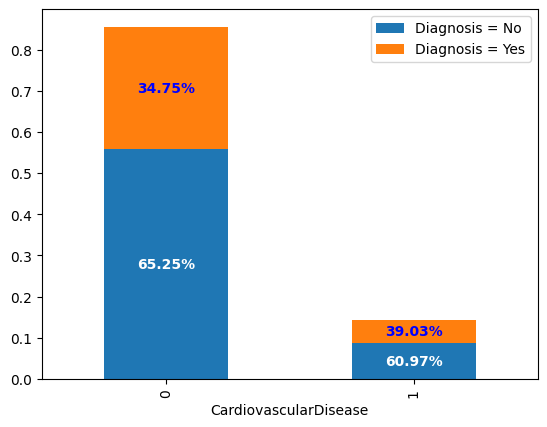

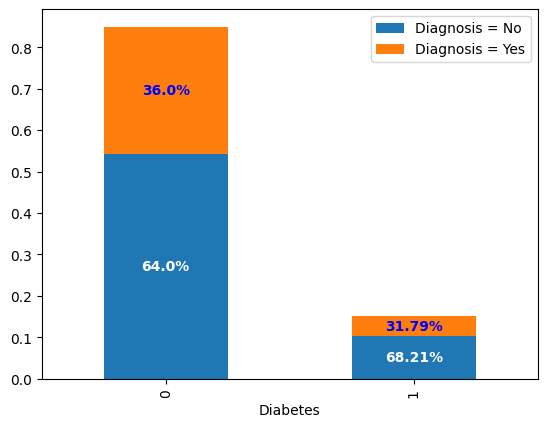

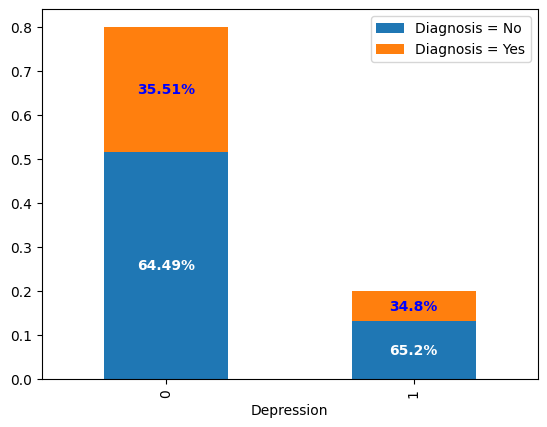

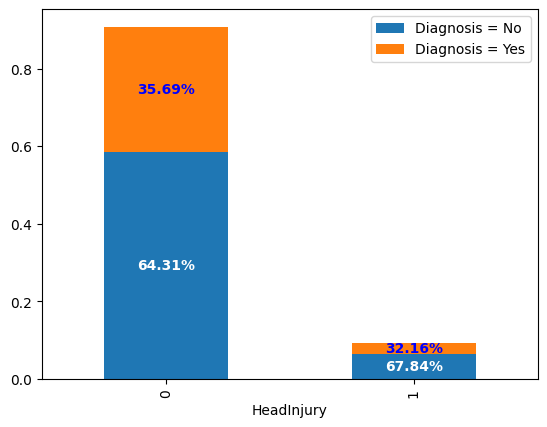

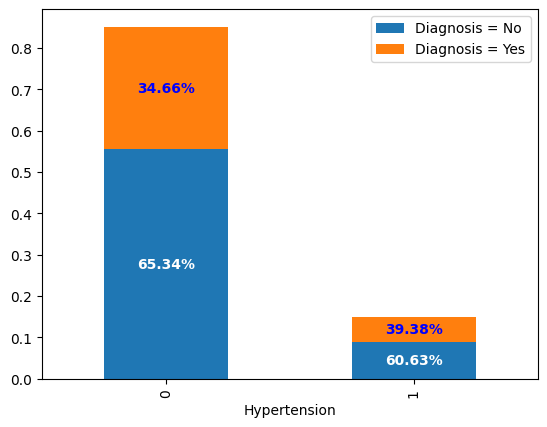

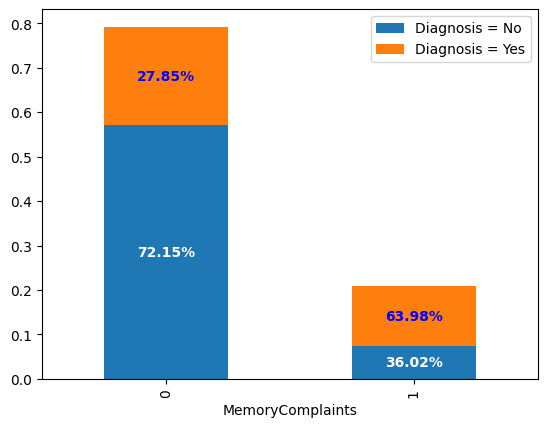

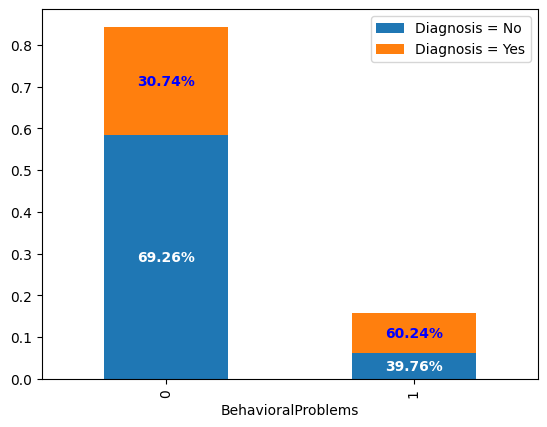

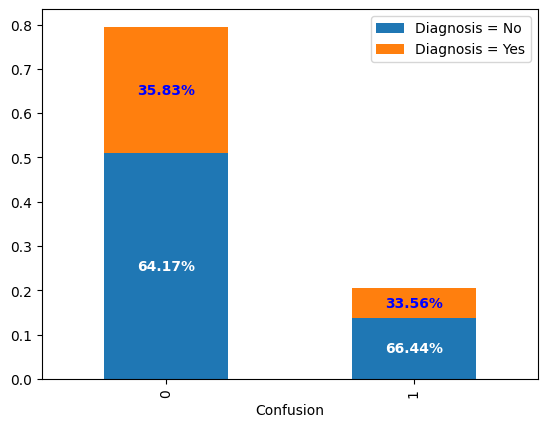

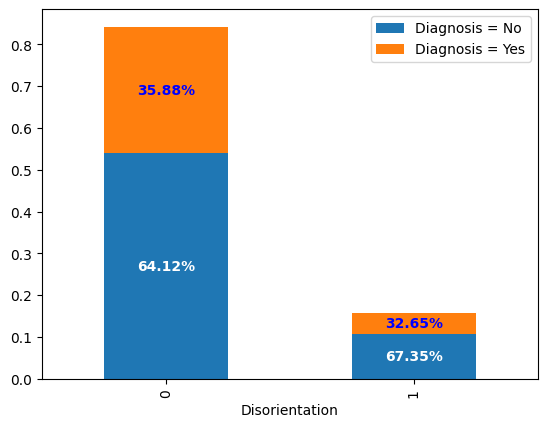

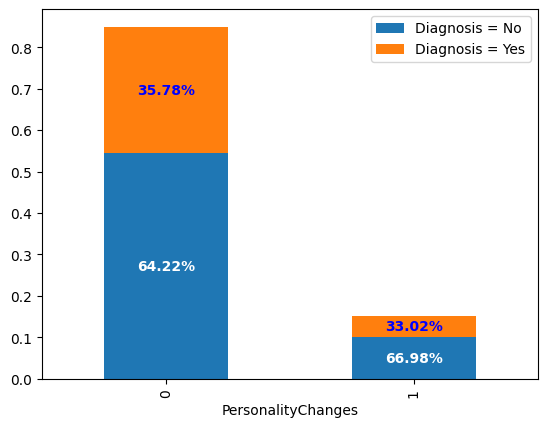

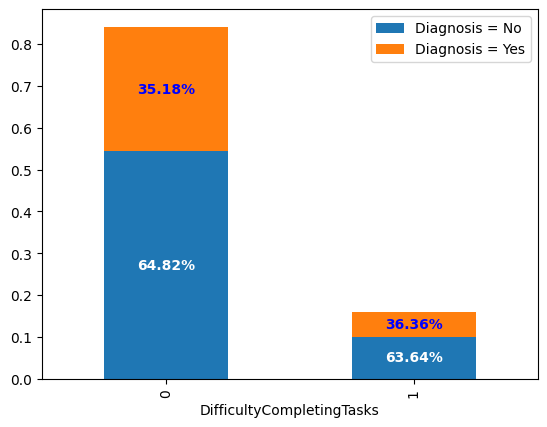

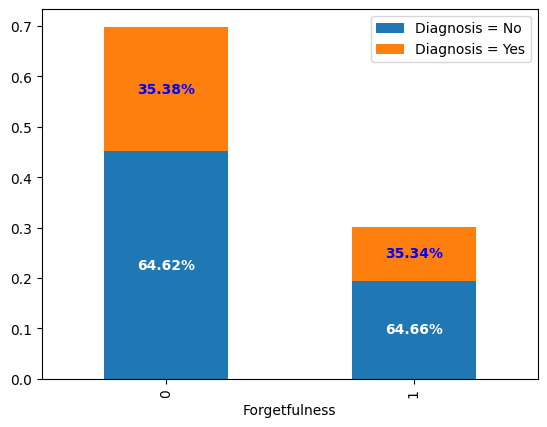

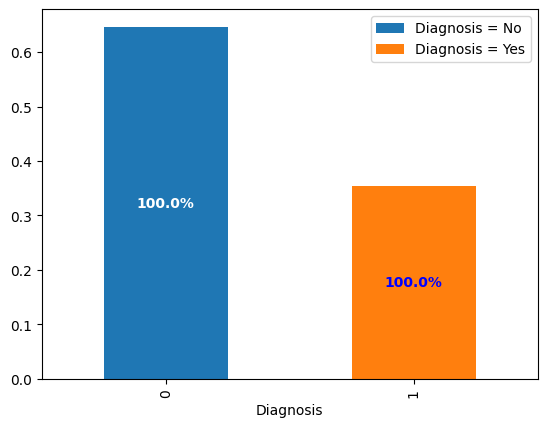

In [10]:
for col in groups['category']:
  ct = pd.crosstab(df[col], df['Diagnosis'], normalize='all')

  # get the total for each row
  total = ct.sum(axis=1)

  # set the colors for each Class
  segment_colors = {'0': 'white', '1': 'blue'}

  # calculate the percent for each row
  per = ct.div(total, axis=0).mul(100).round(2)  # iterate through the containers

  ax = ct.plot(kind='bar', stacked=True,)
  plt.legend(['Diagnosis = No', 'Diagnosis = Yes'])
  for c in ax.containers:

      # get the current segment label (a string); corresponds to column / legend
      label = c.get_label()

      # create custom labels with the bar height and the percent from the per column
      # the column labels in per and dfp are int, so convert label to int
      #labels = [f'{v.get_height()}\n({row}%)' if v.get_height() > 0 else '' for v, row in zip(c, per[int(label)])]
      labels = [f'{row}%' if v.get_height() > 0 else '' for v, row in zip(c, per[int(label)])]

      # add the annotation
      ax.bar_label(c, labels=labels, label_type='center', fontweight='bold', color=segment_colors[label])

  # move the legend


## Data Preparation

The categorical columns of the Alzheimer’s Disease Dataset could be one-hot encoded during data preprocessing. Any of the numeric columns could be standardized such that they reflect a normal distribution if they are found to be normally distributed while others could be linearly scaled to reduce the effect of bias in any machine learning models for the dataset. The sanitized columns in the dataset could also be dropped since they provide no useful information.

### Drop additional features
After reviewing the profile report and other visualizations we have determined that Ethnicity, Gender and EducationLevel will provide no value to our study. Ehtnicity is imbalanced and bias, Gender and Education Level have about the same diagnosis split as the entire set.

In [59]:
# Drop additional columns
df = df.drop(['Ethnicity', 'Gender', 'EducationLevel'], axis=1)
df.head()



,Age,Gender,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,...,6.045039,0,0,0.014691,0,0,1,1,0,0
